# Lecture 4: Performance analysis


In [2]:
import datetime
now = datetime.datetime.now()
print("Version: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Version: 2020-02-06 21:19:05


# Examining datasets

Use the MNIST digit dataset as a worked example in this lecture.

## Fetch MNIST data

In [3]:
# Common imports
import os
import numpy as np
np.random.seed(42) # To make this notebook's output stable across runs

# Fetch MNIST dataset
import requests  
  
url = "https://drive.google.com/uc?export=download&id=1_DqI-pH7gV5RuWxQ4IT1U7PrmSLLhc2a"
mnist = requests.get(url)
with open('mnist.npz', 'wb') as f:
    f.write(mnist.content)


## Extract features and targets

MNIST dataset is already split into standard training set (first 60,000 images) and test set (last 10,000 images).

In [4]:
mnist = np.load('mnist.npz')
X_train, y_train = mnist['x_train'], mnist['y_train']
X_test, y_test = mnist['x_test'], mnist['y_test']

y_train.shape, y_test.shape, type(y_train)

((60000,), (10000,), numpy.ndarray)

In [5]:
X_train.shape, X_test.shape, type(X_train)

((60000, 28, 28), (10000, 28, 28), numpy.ndarray)

Each datum corresponds to a 28 x 28 image.

Reshape X_train and X_test to a 2D array

In [10]:
X_train = X_train.reshape(60000, 28*28)
X_test = X_test.reshape(10000, 28*28)
X_train.shape
# X_train

(60000, 784)

In [69]:
import math
n_float = np.sqrt(X_train.shape[1])
n = math.floor(n_float)
print(n_float, n)

28.0 28


## Plot image of digit

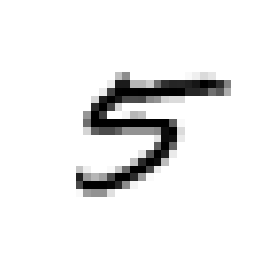

In [72]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

some_digit = X_train[41000]
some_digit_image = some_digit.reshape(n, n)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off");

### Exercise: Compute number of examples of each digit.

In [8]:
n_digits = 10
for i in range(n_digits):
    print(i, X_train[np.where(y_train == i)].shape[0])

0 5923
1 6742
2 5958
3 6131
4 5842
5 5421
6 5918
7 6265
8 5851
9 5949


## Plot selection of digits

In [9]:
# Extract digits
n_images = 10
example_images = np.zeros([n_images * n_digits, n*n])
for i in range(n_digits):
    example_images[i*n_images:(i+1)*n_images,:] =  X_train[np.where(y_train == i)][0:n_images,:]

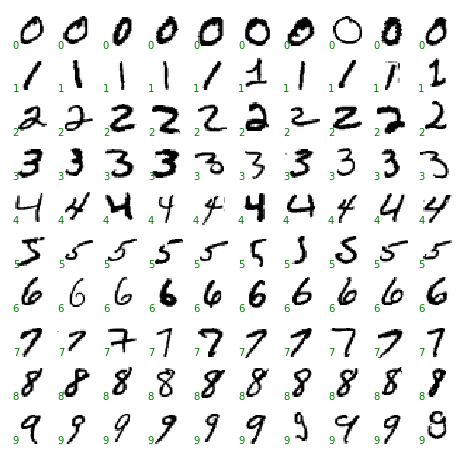

In [10]:
# Plot digits
plt.figure(figsize=(10,10))
fig, axes = plt.subplots(n_digits, n_images, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(example_images[i].reshape(n,n), cmap='binary', interpolation='nearest')
    ax.axis("off")
    ax.text(0.05, 0.05, str(i // n_images),
            transform=ax.transAxes, color='green')

In [11]:
def plot_digit(data):
    image = data.reshape(n, n)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off");

Shuffle training data so not ordered by type.

In [12]:
# Shuffle training data
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Binary classifier

Construct a classify to distinguish between 5s and all other digits.

### Exercise: construct target train and test vectors for 5 classifier.

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
y_test_5

array([False, False, False, ..., False,  True, False])

## Train

Train a linear model using Stochastic Gradient Descent (good for large data-sets, as we will see later...).

In [15]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42, max_iter=10);
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=10, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

Recall extracted `some_digit` previously, which was a 5.

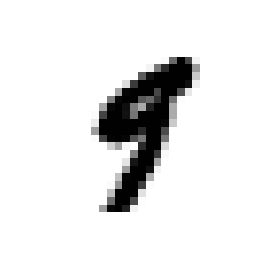

In [16]:
plot_digit(some_digit)

Predict class:

In [17]:
some_digit.shape

sgd_clf.predict([some_digit])


array([False])

## Test accuracy

In [18]:
y_test = sgd_clf.predict(X_test)

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_5)

0.9575

# Cross-validation

## n-fold cross-validation

<center><img src="Lecture04_Images/5-fold-CV.png" style="width: 700px;"/></center>

[Image credit: [VanderPlas](https://github.com/jakevdp/PythonDataScienceHandbook)]

### Exercise: use Scikit-Learn to perform 3-fold cross validation using [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.94545, 0.965  , 0.9546 ])

Around 95% accuracy seems fairly good.

## Consider naive classifier 

Classify everying as not 5.

In [21]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

What accuracy expect?

In [22]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90745, 0.9125 ])

Need to go beyond cross-validation, especially for skewed datasets.

# Confusion matrix

Can gain further insight into performance by examining confusion matrix.

## Cross-validation prediction

`cross_val_predict` performs K-fold cross-validation, returing predictions made on each test fold.  Get clean prediction on each test fold, i.e. clean prediction for each instance in the training set.

In [23]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

## Compute confusion matrix

In [24]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_train_5, y_train_pred)
conf_matrix

array([[53665,   914],
       [ 1785,  3636]])

Each row represents actual class, while each colum represents predicted class.

### Perfect confusion matrix

In [25]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## Confusion matrix shows true/false-positive/negative classifications

- True-positive $\text{TP}$: number of true positives (i.e. *correctly classified* as *positive*)
- False-positive $\text{FP}$: number of false positives (i.e. *incorrectly classified* as *positive*)
- True-negative $\text{TN}$: number of true negatives (i.e. *correctly classified* as *negative*)
- False-negative $\text{FN}$: number of false negatives (i.e. *incorrectly classified* as *negative*)


### Exercise: Specify which enteries of the confusion matrix are TP, FP, TN and FN.

<table>
  <tr>
    <td></td>
    <td></td>
    <td>**Predicted**</td>
    <td></td>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td>**Actual**</td>
    <td>Negative</td>
    <td>TN</td>
    <td>FP</td>
  </tr>
  <tr>
    <td></td>
    <td>Positive</td>
    <td>FN</td>
    <td>TP</td>
  </tr>
</table>

# Precision and recall

- **Precision**: of predicted positives, proportion that are correctly classified (also called *positive predictive value*).
$$\text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$


- **Recall**: of actual positives, proportion that are correctly classified (also called *true positive rate* or *sensitivity*).
$$\text{recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

Remember:
<table>
  <tr>
    <td></td>
    <td></td>
    <td>**Predicted**</td>
    <td></td>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td>**Actual**</td>
    <td>Negative</td>
    <td>TN</td>
    <td>FP</td>
  </tr>
  <tr>
    <td></td>
    <td>Positive</td>
    <td>FN</td>
    <td>TP</td>
  </tr>
</table>

### Execise: compute the precision and recall for the confusion matrix `conf_matrix` computed above.

Compute by hand and then using Scikit-Learn [precision_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) and [recall_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score).

In [26]:
conf_matrix

array([[53665,   914],
       [ 1785,  3636]])

In [27]:
TN, FP, FN, TP = conf_matrix[0,0], conf_matrix[0,1], conf_matrix[1,0], conf_matrix[1,1]
TN, FP, FN, TP

(53665, 914, 1785, 3636)

In [28]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)
precision, recall

(0.7991208791208791, 0.6707249584947427)

In [29]:
from sklearn.metrics import precision_score, recall_score
precision_sklearn = precision_score(y_train_5, y_train_pred)
recall_sklearn = recall_score(y_train_5, y_train_pred)
precision_sklearn, recall_sklearn

(0.7991208791208791, 0.6707249584947427)

## $F_1$ score

$F_1$ score is the *harmonic mean* of the precision and recall.

$$F_1 = \frac{2}{1/\text{precision} + 1/\text{recall}} = 2 \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} = \frac{\text{TP}}{\text{TP} + \frac{\text{FN}+\text{FP}}{2}}$$

### Exercise: compute the $F_1$ score for the confusion matrix `conf_matrix` computed above.

Compute by hand and then using Scikit-Learn [f1_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html).

In [30]:
conf_matrix

array([[53665,   914],
       [ 1785,  3636]])

In [31]:
f1 = TP / (TP + (FN+FP)/2)
f1

0.7293150135392639

In [32]:
from sklearn.metrics import f1_score
f1_sklearn = f1_score(y_train_5, y_train_pred)
f1_sklearn

0.7293150135392639

$F_1$ favours classifiers that have similar (and high) precision and recall.

Sometimes may wish to favour precision or recall.

# Precision-recall tradeoff

Under the hood the classifier computes a *score*.  Binary decision is then made depending on whether score exceeds some *threshold*.

By changing the threshold, one can change the tradeoff between
precision and recall.

Scikit-Learn does not let you set the threshold directly but can access scores (confidence score for a sample is, e.g., the signed distance of that sample to classifying hyperplane).

In [33]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-177165.3613566])

Can then make prediction for given threshold.

In [34]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [35]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

### Compute precision and recall for range of thresholds

In [36]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
#y_scores = y_scores[:,1] # uncomment to handle bug in scikit-learn 0.19.0

In [37]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

(-700000, 700000)

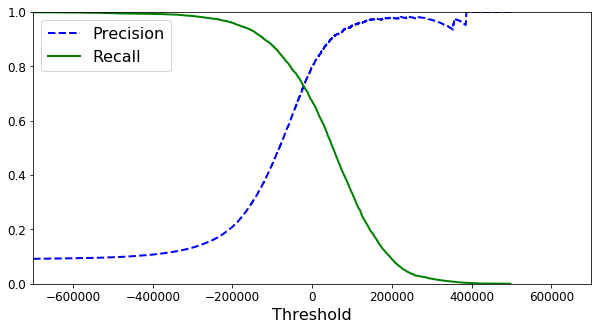

In [38]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(10, 5))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])

*Raising* the threshold *increases precision* and *reduces recall*.

Can select threshold of appropriate trade-off for problem at hand.

Note recall curve smoother than precision since recall related to actual positives and precision related to predicted positives.

# ROC curve

*Receiver operating characteristic* (ROC) curve plots *true positive rate* (i.e. recall) against the *false positive rate* for different *thresholds*.

### Exercise: compute the false positive rate for the confusion matrix `conf_matrix` computed above.

In [39]:
conf_matrix

array([[53665,   914],
       [ 1785,  3636]])

Recall:
<table>
  <tr>
    <td></td>
    <td></td>
    <td>**Predicted**</td>
    <td></td>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td>**Actual**</td>
    <td>Negative</td>
    <td>TN</td>
    <td>FP</td>
  </tr>
  <tr>
    <td></td>
    <td>Positive</td>
    <td>FN</td>
    <td>TP</td>
  </tr>
</table>

In [40]:
false_positive = FP / (FP + TN)
false_positive

0.01674636765056157

## Plot ROC curve

In [41]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

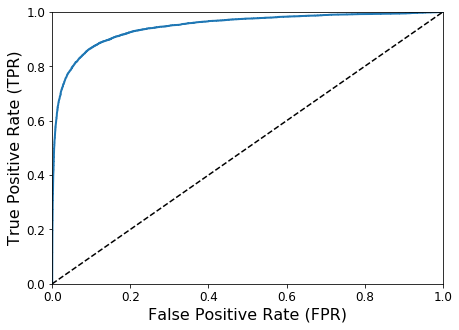

In [42]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(7, 5))
plot_roc_curve(fpr, tpr)

### Exercise: where is the ideal point in the ROC curve domain?

Ideal point is $\text{FPR} = 0$ and $\text{TPR} = 1$, i.e. top left corner. 

Dashed line corresponds to random classifier.

Again, there is a trade-off.  As the threshold is reduced to increase the true positive rate, we get a larger false positive rate.

## Area under the ROC curve

Area under the ROC curve (AUC) is a common performance metric.

In [43]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9469876204453144

###  Exercise: What is the AUC for an ideal and random classifier?

- Ideal classifier: $\text{AUC} = 1$
- Random classifier: $\text{AUC} = 0.5$

## Comparing classifier ROC curves

In [44]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [45]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

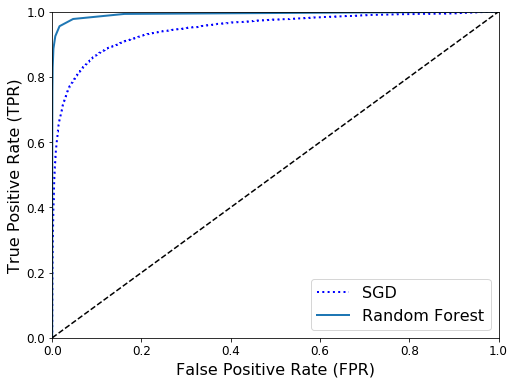

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)

### Exercise: from the ROC curve, which methods appears to work better?

Random Forests since get closer to the ideal point (i.e. top left of plot).

## Comparing metrics

In [47]:
# AUC
roc_auc_score(y_train_5, y_scores_forest), roc_auc_score(y_train_5, y_scores)

(0.9928250745111685, 0.9469876204453144)

In [48]:
# Precision
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest), precision_score(y_train_5, y_train_pred)

(0.9870386643233744, 0.7991208791208791)

In [49]:
# Recall
recall_score(y_train_5, y_train_pred_forest), recall_score(y_train_5, y_train_pred)

(0.8288138719793396, 0.6707249584947427)

In [50]:
# F_1
f1_score(y_train_5, y_train_pred_forest), f1_score(y_train_5, y_train_pred)

(0.9010327885290285, 0.7293150135392639)

## Progress so far

In [51]:
from IPython.display import HTML
HTML('<iframe width="720" height="480" src="https://www.youtube.com/embed/ACmydtFDTGs?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

# Multiclass classification

Binary classifiers distinguish between two classes.
Multiclass classifiers can distinguish between more than two classes.

Some algorithms can handle multiple classes directly (e.g. Random Forests, naive Bayes).
Others are strictly binary classifiers (e.g. Support Vector Machines, Linear classifiers).

## Multiclass classification strategies


However, there are various strategies that can be used to perform multiclass classification with binary classifiers.

- **One-versus-rest (OvR) / one-versus-all (OvA)**: train a binary classifier for each class, then select classification with greatest score across classifiers 
<br>(e.g. train a binary classifier for each digit).

- **One-versus-one (OvO)**: train a binary classifier for each pair of classes, then select classification that wins most duels 
<br>(e.g. train a binary classifier for each pairs of digits: 0 vs 1, 0 vs 2, ..., 1 vs 2, 1 vs 3, ...).

## Comparison of multiclass classification strategies

**One-versus-rest (OvR)**:
- $N$ classifiers for $N$ classes
- each classifier uses all of the training data

$\Rightarrow$ requires training relatively *few classifiers* but training each classifier can be *slow*.

**One-versus-one (OvO)**:
- $N(N-1)/2$ classifiers  for $N$ classes
- each classifier uses a subset of the training data (typically much smaller than overall training dataset)

$\Rightarrow$ requires training *many* classifiers but training each classifier can be *fast*.

## Preferred approach

Unless training binary classifier is very slow with large data-sets, OvR usually preferred.

In Scikit-Learn, if try to use binary classifier for a multiclass classification problem, OvR is automatically run.

In [52]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([4], dtype=uint8)

Can see OvR
performed by inspecting scores, where we have a score per classifier.  

The 5th score (starting from 0) is clearly largest.

In [53]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-383515.20115331, -238766.70247954, -324641.01628213,
         -83203.66235031,   20539.03579365, -177165.3613566 ,
        -378581.74049161,  -78702.02633268, -120260.88520755,
        -117442.14613929]])

In [54]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [55]:
sgd_clf.classes_[np.argmax(some_digit_scores)]

4

## OvO with Scikit-Learn

Can also perform OvO multiclass classification.

In [56]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=10))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit]), len(ovo_clf.estimators_)

(array([9], dtype=uint8), 45)

## Many classifiers can inherently classify multiple classes

Random Forest can directly classify multiple classes so OvR or OvO classification not required.

In [57]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([9], dtype=uint8)

In [58]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0.9]])

In [59]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87117576, 0.86619331, 0.87953193])

## Error analysis

Compute confusion matrix for multiclass classification.

In [60]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5753,    2,   13,   18,   15,   25,   31,    7,   48,   11],
       [   1, 6542,   46,   13,    7,   20,    7,   14,   83,    9],
       [  61,   76, 5269,  120,   63,   25,   82,   71,  157,   34],
       [  54,   56,  279, 4910,   31,  449,   30,   61,  139,  122],
       [  24,   39,   31,   21, 4913,   19,   61,   55,  144,  535],
       [ 102,   56,   55,  337,   77, 4281,  101,   30,  270,  112],
       [  64,   35,   64,   20,   42,  122, 5496,    6,   63,    6],
       [  27,   30,   82,   48,   65,   14,    4, 5632,   46,  317],
       [  55,  245,  131,  269,   82,  287,   33,   38, 4477,  234],
       [  44,   44,   22,   81,  267,   63,    2,  246,  115, 5065]])

### Exercise: convert confusion matrix to probabilities and plot.

In [61]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [1]:
import seaborn as sns
plt.figure(figsize=(6,6))
sns.heatmap(norm_conf_mx, square=True, annot=True, cbar=False, fmt='.2f')
plt.xlabel('predicted value')
plt.ylabel('true value');

NameError: name 'plt' is not defined

Performance analysis can provide insight into how to make improvements.

For example, for the previous dataset, one might want to consider trying to improve the performane of classifying 9 by collecting more training data for 7s and 9s.